In [80]:
## From: https://towardsdatascience.com/web-scraping-craigslist-a-complete-tutorial-c41cea4f4981

#import get to call a get request on the site
from requests import get

#get the first page of the housing prices
response = get('https://minneapolis.craigslist.org/search/apa?hasPic=1&availabilityMode=0') #get rid of those lame-o's that post a housing option without a pic using their filter

from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')

#get the macro-container for the housing posts
posts = html_soup.find_all('li', class_= 'result-row')
print(type(posts)) #to double check that I got a ResultSet
print( len(posts)) #to double check I got 120 (elements/page)
post = posts[0]

<class 'bs4.element.ResultSet'>
120


In [81]:
print(post)

<li class="result-row" data-pid="7122217022">
<a class="result-image gallery" data-ids="1:01414_hPgD8rBvcfl,1:00000_1mlIXgADOpC,1:00O0O_3kClBazR10b,1:00r0r_eP35TiDaZ7b,1:01414_94BKLZLyR9M,1:01111_hYMURlDQEEV,1:00W0W_ibENZp1h0zH,1:00I0I_f9cGJRuKT8Q" href="https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-all-utilities-included-soft/7122217022.html">
<span class="result-price">$1395</span>
</a>
<p class="result-info">
<span class="icon icon-star" role="button">
<span class="screen-reader-text">favorite this post</span>
</span>
<time class="result-date" datetime="2020-06-04 18:01" title="Thu 04 Jun 06:01:00 PM">Jun  4</time>
<a class="result-title hdrlnk" data-id="7122217022" href="https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-all-utilities-included-soft/7122217022.html">All Utilities Included, Soft-close Cabinetry, Green Space</a>
<span class="result-meta">
<span class="result-price">$1395</span>
<span class="housing">
                    318ft<sup>2</sup> -
           

In [82]:
curtime = post.find('time',class_='result-date')['datetime']
print(curtime)
cururl = post.find('a',class_='result-title hdrlnk')['href']
print(cururl)

2020-06-04 18:01
https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-all-utilities-included-soft/7122217022.html


In [83]:
#curbrs = post.find('span', class_ = 'housing').text.split()[0][:-2]
#print(curbrs)

#cursqft = post.find('span', class_ = 'housing')
#if cursqft:
#    cursqft = cursqft.text.split()[2][:-3] #cleans the ft2 at the end
#    print(cursqft)
#print(cursqft)

curhood = post.find('span', class_='result-hood') 
if curhood:
    curhood = curhood.text
    print(curhood)



 (Dinkytown)


In [84]:
from geopy.geocoders import Nominatim, ArcGIS
curmap = BeautifulSoup(get(cururl).text,'html.parser').find_all('div',class_='mapbox')[0]
geolocator = Nominatim(user_agent="darren")

print(curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'])

location = geolocator.reverse(query=curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'])


geolocator2 = ArcGIS(user_agent="darren")
location2 = geolocator2.reverse(query=curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'],
                                distance=500)





import numpy as np

loc = geolocator.reverse(query=str(np.round(float(curmap.find('div')['data-latitude'])-.001,3))
                   +","
                   +str(np.round(float(curmap.find('div')['data-longitude'])-.001,3)))
    
print(location.address)
print(location2.address)
print(loc.address)

#print(location.raw['address'])
#print(location.raw['address']['city'])
#print(location.raw['address']['neighbourhood'])
#print(location.raw['address']['postcode'])

44.982031,-93.239654
1103, Southeast 4th Street, Marcy-Holmes, Phillips, Minneapolis, Hennepin County, Minnesota, 55414, United States of America
1120 SE 4th St, Minneapolis, Minnesota 55414, USA
C-45, 13, Southeast 11th Avenue, Marcy-Holmes, Phillips, Minneapolis, Hennepin County, Minnesota, 55455, United States of America


In [85]:
curpost = get(post.find('a', class_='result-title hdrlnk')['href']).text
curmap = BeautifulSoup(curpost,'html.parser').find_all('div',class_='mapbox')
print(curmap)

[<div class="mapbox">
<div class="viewposting" data-accuracy="5" data-latitude="44.982031" data-longitude="-93.239654" id="map"></div>
<div class="mapaddress">1119 4th ST SE - 405</div>
<p class="mapaddress">
<small>
            (<a href="https://www.google.com/maps/search/44.982031,-93.239654" target="_blank">google map</a>)
        </small>
</p>
</div>]


In [86]:
#new code to put here:
#get list of neighborhoods
#for each neighborhood,
#  get central coordinate
#for each posting
#  calculate distance from neighborhoods' centers
#  assign neighborhood based on nearest neighbor

In [139]:
#linkpfx = 'https://minneapolis.craigslist.org/search/apa?'
#linksfx =( 'sort=date'
#          +'&hasPic=1'
#          +'&bundleDuplicates=1'
#          +'&search_distance=20'
#          +'&postal=55454'
#          +'&min_price=500'
#          +'&max_price=4000'
#          +'&max_bedrooms=3'
#          +'&availabilityMode=0'
#          +'&sale_date=all+dates')
#response = get(linkpfx+linksfx)
#html_soup = BeautifulSoup(response.text, 'html.parser')
#results_num = html_soup.find('div', class_= 'search-legend')
#results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array
#pages = np.arange(0, results_total+1, 120)
#print(results_total)
#print(pages)

3000
[   0  120  240  360  480  600  720  840  960 1080 1200 1320 1440 1560
 1680 1800 1920 2040 2160 2280 2400 2520 2640 2760 2880 3000]


In [390]:
#build out the loop
from bs4 import BeautifulSoup
from time import sleep, time
import re
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from IPython.core.display import clear_output
import numpy as np


linkpfx = 'https://minneapolis.craigslist.org/search/apa?'
linksfx =( 'sort=date'
          +'&hasPic=1'
          +'&bundleDuplicates=1'
          +'&search_distance=20'
          +'&postal=55454'
          +'&min_price=400'
          +'&max_price=4000'
          +'&max_bedrooms=3'
          +'&availabilityMode=0'
          +'&sale_date=all+dates')
response = get(linkpfx+linksfx)
html_soup = BeautifulSoup(response.text, 'html.parser')
results_num = html_soup.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array
pages = np.arange(0, results_total+1, 120)


from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="derinkuyu",timeout=3)

#
TypeDict = {
    'apartment': 1, 
    'condo':2, 
    'cottage/cabin':3, 
    'duplex':4, 
    'flat':5, 
    'house':6, 
    'in-law':7, 
    'loft':8, 
    'townhouse':9, 
    'manufactured':10, 
    'assisted living':11, 
    'land':12}
LaundryDict = {
    'w/d in unit':1,
    'w/d hookups':2,
    'laundry in bldg':3,
    'laundry on site':4,
    'no laundry on site':5
}    
ParkingDict = {
    'carport':1,
    'attached garage':2,
    'detached garage':3,
    'off-street parking':4,
    'street parking':5,
    'valet parking':6,
    'no parking':7
}



iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
bedroom_counts = []
sqfts = []
post_links = []
post_prices = []


cities = []
towns = []
neighborhoods = []
zips = []


types = []
laundries = []
parkings = []

for page in pages:
    
    #get request
    response = get(linkpfx
                   + 's=' #parameter for defining page number
                   + str(page) #page in above array
                   + linksfx)    
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #define the posts
    posts = html_soup.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:
        #sleep(1.1)
        
        curpost = get(post.find('a', class_='result-title hdrlnk')['href']).text
        curmap = BeautifulSoup(curpost,'html.parser').find_all('div',class_='mapbox')
        
        if (post.find('span', class_ = 'result-hood') is not None) and curmap:

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            #
            #curpost = get(post_link).text
            curmap = curmap[0] #BeautifulSoup(curpost,'html.parser').find_all('div',class_='mapbox')[0]
            location = geolocator.reverse(curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'])
            
            try: 
                cities.append(location.raw['address']['city'])
            except:
                try: 
                    cities.append(location.raw['address']['town'])
                except:
                    cities.append('')
            
            try: 
                towns.append(location.raw['address']['town'])
            except:
                towns.append('')
            
            try:
                neighborhoods.append(location.raw['address']['neighbourhood'])
            except:
                try: 
                    locshift1 = geolocator.reverse( str(float(curmap.find('div')['data-latitude'])+.001)+","+str(float(curmap.find('div')['data-longitude'])+.001))
                    neighborhoods.append(locshift1.raw['address']['neighbourhood'])
                except:                   
                    try: 
                        locshift2 = geolocator.reverse( str(float(curmap.find('div')['data-latitude'])-.001)+","+str(float(curmap.find('div')['data-longitude'])-.001))
                        neighborhoods.append(locshift2.raw['address']['neighbourhood'])
                    except:
                        try:
                            neighborhoods.append(location.raw['address']['town'])
                        except:
                            try:
                                neighborhoods.append(location.raw['address']['city'])
                            except:
                                neighborhoods.append('')
                    #except:
                    #    try: 
                    #        locshift3 = geolocator.reverse( str(float(curmap.find('div')['data-latitude'])+.001)+","+str(float(curmap.find('div')['data-longitude'])-.001))
                    #        neighborhoods.append(locshift3.raw['address']['neighbourhood'])
                    #    except:
                    #        try:
                    #            locshift4 = geolocator.reverse( str(float(curmap.find('div')['data-latitude'])-.001)+","+str(float(curmap.find('div')['data-longitude'])+.001))
                    #            neighborhoods.append(locshift4.raw['address']['neighbourhood'])
                    #        except:
                    #            neighborhoods.append('')
            
            try:
                zips.append(location.raw['address']['postcode'])
            except:
                zips.append('')
            
            try:
                curattr = BeautifulSoup(curpost,'html.parser').find_all('p',class_='attrgroup')[1]
                typename = list(set(curattr.text.split('\n')).intersection(list(TypeDict.keys())))[0]
                types.append(TypeDict[typename])
            except:
                types.append('')
            
            try:
                curattr = BeautifulSoup(curpost,'html.parser').find_all('p',class_='attrgroup')[1]
                laundryname = list(set(curattr.text.split('\n')).intersection(list(LaundryDict.keys())))[0]
                laundries.append(LaundryDict[laundryname])
            except:
                laundries.append('')
            
            try:
                curattr = BeautifulSoup(curpost,'html.parser').find_all('p',class_='attrgroup')[1]
                parkname = list(set(curattr.text.split('\n')).intersection(list(ParkingDict.keys())))[0]
                parkings.append(ParkingDict[parkname])
            except:
                parkings.append('')
            
            #removes the \n whitespace from each side, removes the currency symbol, and turns it into an int
            post_price = int(post.a.text.strip().replace("$", "")) 
            post_prices.append(post_price)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            
    iterations += 1
    print("Page " + str(iterations) + " scraped successfully!")

print("\n")

print("Scrape complete!")

import pandas as pd

apts = pd.DataFrame({
    'posted': post_timing,
    'neighborhood': post_hoods,
    'post title': post_title_texts,
    'number bedrooms': bedroom_counts,
    'sqft': sqfts,
    'URL': post_links,
    'price': post_prices,
    'cities':cities,
    'towns':towns,
    'neighborhoods':neighborhoods,
    'zips': zips,
    'types':types,
    'parking':parkings,
    'laundry':laundries})
#print(apts.info())
#apts.head(30)
apts.shape

#drop duplicates
apts = apts.drop_duplicates(subset=['URL','sqft','number bedrooms'])

#make the number bedrooms to a float (since np.nan is a float too)
apts['number bedrooms'] = apts['number bedrooms'].apply(lambda x: float(x))

#convert datetime string into datetime object to be able to work with it
from datetime import datetime

apts['posted'] = pd.to_datetime(apts['posted'])

#Looking at what neighborhoods there are with apts['neighborhood'].unique() allowed me to see what
#I needed to deal with in terms of cleaning those.

##remove the parenthesis from the left and right of the neighborhoods
#apts['neighborhood'] = apts['neighborhood'].map(lambda x: x.lstrip('(').rstrip(')'))
#
##titlecase them
#apts['neighborhood'] = apts['neighborhood'].str.title()
#
##just take the first name of the neighborhood list, splitting on the '/' delimiter
#apts['neighborhood'] = apts['neighborhood'].apply(lambda x: x.split('/')[0])
#
##fix one-offs that
#apts['neighborhood'].replace('Belmont, Ca', 'Belmont', inplace=True)
#apts['neighborhood'].replace('Hercules, Pinole, San Pablo, El Sob', 'Hercules', inplace=True)
#
##remove whitespaces
#apts['neighborhood'] = apts['neighborhood'].apply(lambda x: x.strip())

#save the clean data

apts.to_csv(path_or_buf='./apts_'+str(datetime.now()).replace(' ','_').replace(':','-')+'.csv', index=False)
apts.shape


Page 1 scraped successfully!
Page 2 scraped successfully!
Page 3 scraped successfully!
Page 4 scraped successfully!
Page 5 scraped successfully!
Page 6 scraped successfully!
Page 7 scraped successfully!
Page 8 scraped successfully!


SSLError: HTTPSConnectionPool(host='minneapolis.craigslist.org', port=443): Max retries exceeded with url: /hnp/apa/d/minneapolis-apply-today-view-west/7135857978.html (Caused by SSLError(SSLError("bad handshake: SysCallError(10060, 'WSAETIMEDOUT')")))

In [194]:
##drop duplicates
#apts = apts.drop_duplicates(subset=['URL','sqft','number bedrooms'])
#
##make the number bedrooms to a float (since np.nan is a float too)
#apts['number bedrooms'] = apts['number bedrooms'].apply(lambda x: float(x))
#
##convert datetime string into datetime object to be able to work with it
#from datetime import datetime
#
#apts['posted'] = pd.to_datetime(apts['posted'])

#Looking at what neighborhoods there are with apts['neighborhood'].unique() allowed me to see what
#I needed to deal with in terms of cleaning those.

##remove the parenthesis from the left and right of the neighborhoods
#apts['neighborhood'] = apts['neighborhood'].map(lambda x: x.lstrip('(').rstrip(')'))
#
##titlecase them
#apts['neighborhood'] = apts['neighborhood'].str.title()
#
##just take the first name of the neighborhood list, splitting on the '/' delimiter
#apts['neighborhood'] = apts['neighborhood'].apply(lambda x: x.split('/')[0])
#
##fix one-offs that
#apts['neighborhood'].replace('Belmont, Ca', 'Belmont', inplace=True)
#apts['neighborhood'].replace('Hercules, Pinole, San Pablo, El Sob', 'Hercules', inplace=True)
#
##remove whitespaces
#apts['neighborhood'] = apts['neighborhood'].apply(lambda x: x.strip())

#save the clean data

#apts.to_csv(path_or_buf='./apts_'+str(datetime.now()).replace(' ','_').replace(':','-')+'.csv', index=False)
#apts.shape

In [333]:
import os
import glob
aptfiles = glob.glob('apts_*')
for file in aptfiles:
    apts = apts.append(pd.read_csv(file),ignore_index=True)
apts = apts.drop_duplicates(subset=['URL','sqft','number bedrooms'])
apts.shape

(563, 14)

In [334]:
print(apts.neighborhoods)

0             Texa Tonka
1       Highland Village
2          Bredesen Park
3               Plymouth
4        Lowry Hill East
              ...       
1218           Richfield
1235               CARAG
1261       Phillips West
1305            St. Paul
1313            Woodbury
Name: neighborhoods, Length: 563, dtype: object


In [335]:
apts.describe()

,number bedrooms,sqft,price,types
count,546.000000,511.000000,563.000000,559.000000
mean,1.734432,1005.236791,1417.207815,1.812165
std,0.745005,519.327424,483.556237,2.142452
min,1.000000,103.000000,475.000000,1.000000
25%,1.000000,727.000000,1095.000000,1.000000
50%,2.000000,900.000000,1349.000000,1.000000
75%,2.000000,1190.000000,1649.500000,1.000000
max,5.000000,8500.000000,3984.000000,9.000000


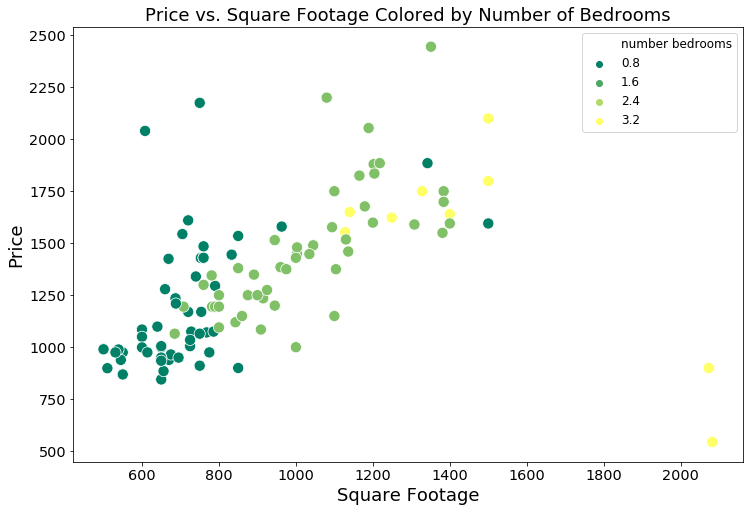

In [336]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.scatterplot(x='sqft', y='price', hue='number bedrooms', palette='summer', x_jitter=True, y_jitter=True, s=125, data=apts.dropna())
plt.legend(fontsize=12)
plt.xlabel("Square Footage", fontsize=18)
plt.ylabel("Price", fontsize=18);
plt.title("Price vs. Square Footage Colored by Number of Bedrooms", fontsize=18);


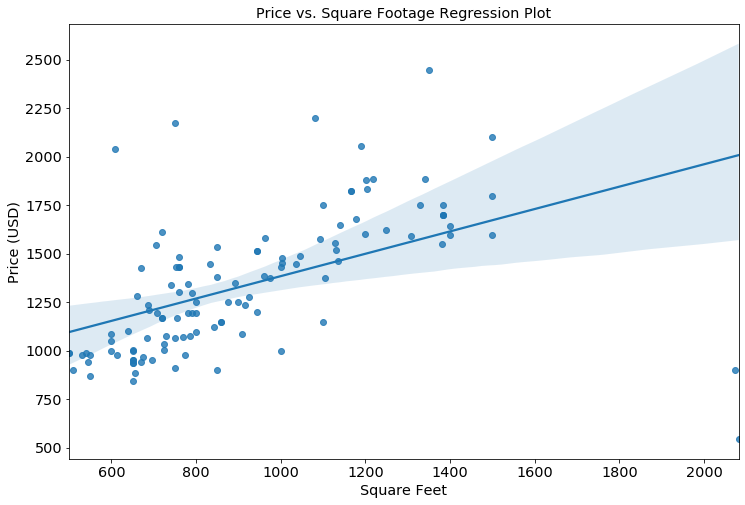

In [337]:
plt.figure(figsize=(12, 8))
sns.regplot(x='sqft', y='price', data=apts.dropna());
plt.title('Price vs. Square Footage Regression Plot');
plt.xlabel("Square Feet");
plt.ylabel("Price (USD)");

In [338]:
apts.corr()

,number bedrooms,sqft,price,types
number bedrooms,1.000000,0.589049,0.322878,0.380786
sqft,0.589049,1.000000,0.341373,0.368103
price,0.322878,0.341373,1.000000,0.118002
types,0.380786,0.368103,0.118002,1.000000


In [339]:
apts[apts['number bedrooms']<=1].groupby('neighborhoods').median()

,number bedrooms,sqft,price,types
neighborhoods,,,,
Anoka,1.0,NaN,895.0,1.0
Apple Valley,1.0,NaN,1095.0,7.0
Aquila,1.0,815.0,1025.0,1.5
Avenida,1.0,1342.0,1885.0,9.0
Blackstone,1.0,730.0,1678.0,1.0
...,...,...,...,...
Wayzata,1.0,785.0,1151.0,1.0
West Calhoun,1.0,600.0,1095.0,1.0
West St. Paul,1.0,750.0,1099.0,1.0


In [340]:
#correct oddly named locations
apts['neighborhoods'].replace('Uptown Minneapolis', 'Uptown', inplace=True)

apts[apts['number bedrooms']<=1].groupby('neighborhoods').median()['price'].sort_values()

neighborhoods
Kingfield           845.0
Anoka               895.0
Richfield           899.0
Powderhorn Park     925.0
Little Canada       935.0
                    ...  
Fulton             1595.0
St Anthony West    1625.0
Blackstone         1678.0
East Calhoun       1747.0
Avenida            1885.0
Name: price, Length: 62, dtype: float64

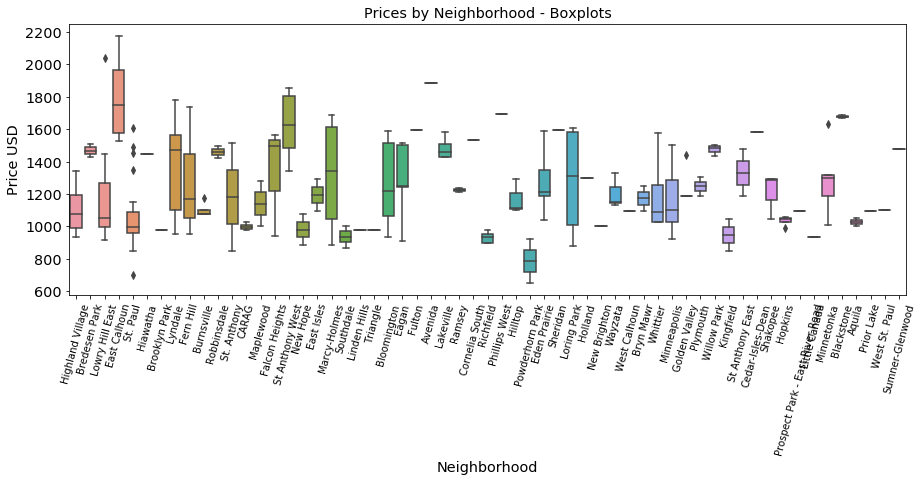

In [356]:
sns.boxplot(x='neighborhoods', y='price', data=apts[apts['number bedrooms']<=1])
plt.xlabel("Neighborhood");
plt.xticks(rotation=75,size=10)
plt.ylabel("Price USD");
plt.title("Prices by Neighborhood - Boxplots");

In [367]:
# drop problematic cols
apts = apts.dropna(subset=['price','number bedrooms','sqft','neighborhoods','types','laundry','parking'])
print(apts.shape)

# recode neighborhoods
apts_onehot = apts.copy()
apts_onehot = pd.get_dummies(apts_onehot, columns=['neighborhoods'], prefix = ['nb'])
apts_onehot = pd.get_dummies(apts_onehot, columns=['types'], prefix = ['ty'])
apts_onehot = pd.get_dummies(apts_onehot, columns=['laundry'], prefix = ['ld'])
apts_onehot = pd.get_dummies(apts_onehot, columns=['parking'], prefix = ['pd'])

print(apts_onehot)

(437, 14)
                  posted                                   neighborhood  \
0    2020-06-05 14:33:00                (Minnetonka Blvd and Xylon Ave)   
1    2020-06-05 14:33:00                    (1759 Grand Ave., St. Paul)   
2    2020-06-05 14:33:00                                    (Edina, MN)   
3    2020-06-05 14:32:00       (14550 34th Ave North Plymouth, MN55447)   
4    2020-06-05 14:25:00                                       (Uptown)   
..                   ...                                            ...   
490  2020-06-05 11:28:00                               (St. Louis Park)   
491  2020-06-05 11:28:00                                 (Eden Prairie)   
492  2020-06-05 11:27:00                          (750 Otto Ave - 2239)   
493  2020-06-05 11:26:00                                    (Maplewood)   
494  2020-06-05 11:26:00   (Near Mall of America and Eagan Outlet Mall)   

                                                                 post title  \
0        H

In [382]:
from sklearn import linear_model

maincols = ['number bedrooms','sqft']
nbcols = [col for col in apts_onehot if col.startswith('nb')]
for c in nbcols:
    maincols.append(c) 
tycols = [col for col in apts_onehot if col.startswith('ty')]
for c in nbcols:
    maincols.append(c) 
pkcols = [col for col in apts_onehot if col.startswith('pk')]
for c in nbcols:
    maincols.append(c) 
ldcols = [col for col in apts_onehot if col.startswith('ld')]
for c in nbcols:
    maincols.append(c) 

    
reg = linear_model.LinearRegression()
y = apts_onehot['price'].values.reshape(-1,1)
X = apts_onehot[maincols].values
#X = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)

reg.fit(y=y,X=X)
#print(reg.coef_)
#print(reg.intercept_)

#
apts_onehot['price_est'] = np.zeros((apts_onehot.shape[0],1))
apts_onehot['price_est'] = reg.predict(X)
apts_onehot['price_dif'] = apts_onehot['price']-apts_onehot['price_est']
apts_onehot['price_difpct'] = (apts_onehot['price_dif'] / apts_onehot['price_est']) * 100

In [386]:
apts_onehot['price_difpct']

0       0.000080
1      -7.049482
2      -6.370815
3      -6.967358
4      78.712449
         ...    
490    -1.891185
491    -9.293326
492    10.013549
493    -8.021948
494    -6.612829
Name: price_difpct, Length: 437, dtype: float64

In [389]:
pd.options.display.max_colwidth = 200

apts_onehot[apts_onehot['price_difpct']<=-10].sort_values('price_difpct',ascending=True)['URL'] #('neighborhoods').median()['price'].sort_values()
#apts_onehot[apts_onehot['price_dif']<=-300].URL #[['price','price_est','price_dif','URL']]

446        https://minneapolis.craigslist.org/wsh/apa/d/minneapolis-fne-dnng-spacous-home-d/7133061709.html
104        https://minneapolis.craigslist.org/csw/apa/d/minneapolis-fne-dnng-spacous-home-d/7133063641.html
131         https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-chrming-house-band-new/7133058520.html
434     https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-super-clean-beautiful-open/7129175541.html
60          https://minneapolis.craigslist.org/hnp/apa/d/saint-paul-great-home-great-garage/7120747708.html
                                                       ...                                                 
307        https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-now-renting-sign-12-mos/7136006965.html
69      https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-sign-up-to-get-the-special/7136430671.html
357      https://minneapolis.craigslist.org/hnp/apa/d/minnetonka-one-bedroom-home-available/7136252714.html
345     https://minneapolis.